In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

#from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.model_selection import learning_curve

from ml_metrics import rmsle, mae

import xgboost as xgb
import gc

from sklearn.dummy import DummyRegressor

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

import sys
import re

In [2]:
train = pd.read_hdf('../input/train.car_price.h5')
test = pd.read_hdf('../input/test.car_price.h5') #zbiór testowy bez odpowiedzi

In [3]:
def num_filter(val):
    return re.sub('[^0-9]','', str(val))

retuce_entries_param =  99.9

df_all = pd.concat([train, test])
del train, test
gc.collect()

obj_feats = list(df_all.select_dtypes(np.object).columns)
obj_feats = [x for x in obj_feats if x.startswith('param') or x.startswith('seller')]

for feat in obj_feats:
    df_all["{}_cat".format(feat)] = df_all[feat].factorize()[0]

In [4]:
df_all["param_miesięczna-rata_cat"] = df_all["param_miesięczna-rata"].fillna(-1)
df_all["param_miesięczna-rata_cat"] = df_all["param_miesięczna-rata_cat"].map(lambda x: x.replace(",", ".") if x!=-1 else x)
df_all["param_miesięczna-rata_cat"] = df_all["param_miesięczna-rata_cat"].map(lambda x: float(x[:-4].replace(" ", "")) if x!=-1 else x)
#df_all["param_miesięczna-rata_cat"].unique()

In [317]:
# df_all["param_wartość-wykupu_cat"] = df_all["param_wartość-wykupu"].fillna(-1)
# df_all["param_wartość-wykupu_cat"] = df_all["param_wartość-wykupu_cat"].map(lambda x: x.replace(",", ".") if x!=-1 else x)

# df_all["param_wartość-wykupu_cat"] = df_all["param_wartość-wykupu_cat"].map(lambda x: float(x[:-4].replace(" ", "")) if x!=-1 else x)
# #df_all["param_wartość-wykupu_cat"].unique()

# df_all["param_pojemność-skokowa_cat"] = df_all["param_pojemność-skokowa"].fillna(-1)
# df_all["param_pojemność-skokowa_cat"] = df_all["param_pojemność-skokowa_cat"].map(lambda x: float(x[:-4].replace(" ", "")) if x!=-1 else x)
# df_all["param_pojemność-skokowa_cat"].unique()

# df_all["param_moc_cat"] = df_all["param_moc"].fillna(-1)
# df_all["param_moc_cat"] = df_all["param_moc_cat"].map(lambda x: int(x[:-3].replace(" ", "")) if x!=-1 else x)

# #df_all["param_moc_cat"].unique()
#df_all["param_airbags_norm"] = np.where((df_all['feature_poduszka-powietrzna-chroniąca-kolana'] == 1) & (df_all['feature_poduszka-powietrzna-pasażera'] == 1) & (df_all['feature_poduszki-boczne-przednie'] == 1) & (df_all['feature_poduszki-boczne-tylne'] == 1), 1, 0)

In [5]:
df_all["param_przebieg_cat"] = df_all["param_przebieg"].fillna(-1)
df_all["param_przebieg_cat"] = df_all["param_przebieg_cat"].map(lambda x: int(x[:-3].replace(" ", "")) if x!=-1 else x)
df_all["param_przebieg_cat"].unique()

array([     1, 209533,  30500, ...,  15894, 212091, 227560])

In [6]:
df_all["param_rok-produkcji_cat"] = df_all["param_rok-produkcji"].fillna(-1)
df_all['param_rok-produkcji_cat'] = df_all['param_rok-produkcji_cat'].astype(np.int)    

In [7]:
df_all["param_moc_norm_new"] = df_all["param_moc"].fillna(-1)
df_all["param_pojemność-skokowa_norm_new"] = df_all["param_pojemność-skokowa"].fillna(-1)

df_all['param_moc_norm_new'] = np.log( df_all['param_moc_norm_new'].map(num_filter).astype(np.int) )
df_all['param_pojemność-skokowa_norm_new'] = np.log( df_all['param_pojemność-skokowa_norm_new'].map(num_filter).astype(np.int) )

In [8]:
black_list = ['car_id', 'price_details', 'price_value']
del_list = [
            'feature_radio-niefabryczne',
            'feature_alarm',
            'feature_klimatyzacja-czterostrefowa',
            'feature_klimatyzacja-dwustrefowa',
            'feature_klimatyzacja-manualna',
            'feature_isofix',
            'feature_tapicerka-welurowa',  
            "param_vin_cat", 
            "seller_address_cat", 
            "seller_name_cat", 
            "param_year_cat",
            "param_co2-emissions_cat",
            "param_engine-power_cat",
            "param_first-registration_cat",
            "param_make_cat",
            "param_fuel-type_cat",
            "param_monthly-payment-value_cat",
            "param_mileage_cat",
            "param_wartość-wykupu_cat",
            "param_vat-discount_cat",
            "param_service-record_cat",
            "param_registered-in-poland_cat",
            "param_original-owner_cat",
            "seller_type_cat",
            "param_model_cat",   
           ]

remove_from_feats_list = black_list + del_list
feats = df_all.select_dtypes(include=[np.number, np.bool]).columns
feats = [x for x in feats if x not in remove_from_feats_list]
print("Feats number:", len(feats) )


Feats number: 126


In [9]:
train = df_all[ ~df_all.price_value.isnull() ].copy()
if train.price_value.max() == 799900:
    train = train[train.price_value < np.percentile( train.price_value, retuce_entries_param )]
else:
    pass
test = df_all[ df_all.price_value.isnull() ].copy()
#del df_all
gc.collect()
train.shape

(106387, 236)

In [323]:
# del train["price_value_pred"]
# del train["pred_diff_abs"]
# del train["pred_diff_percent"]
# del train["pred_diff"]

In [324]:
train.shape

(106387, 236)

In [10]:
train["param_pojemność-skokowa_cat"] = train["param_pojemność-skokowa_cat"].map(lambda x: -1 if x>15000 else x)
train["param_moc_cat"] = train["param_moc_cat"].map(lambda x: -1 if x>11000 else x)
train = train[ train["price_currency"] == "PLN" ]

In [32]:
value_counts_row = train['param_marka-pojazdu'](lambda x: x.value_counts())


TypeError: 'Series' object is not callable

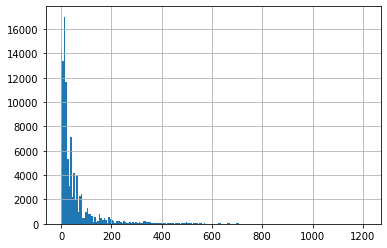

In [11]:
train["param_pojemność-skokowa_cat"].hist(bins=200)

In [12]:
# rate_d = []
# rate_x = []

In [13]:
def run_cv(model, X, y, folds=None, target_log=False,cv_type=KFold, success_metric=mae):
    cv = cv_type(n_splits=folds)
    price_value_pred = {}
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 #czasem może być wartość ujemna

        score = success_metric(y_test, y_pred)
        scores.append( score )        
        price_value_pred.update( dict(zip(list(test_idx), list(y_pred))) )
        
    train['price_value_pred'] = train.index.map(price_value_pred)       
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(8,6))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return rmsle(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt



In [14]:
def run(train, plot_lc=True, plot_imp=True, folds=7, ylim=(0, 2), target_log=True, feats=feats):
    feats = [x for x in feats if x not in remove_from_feats_list]
    X = train[feats].values
    y = train["price_value"].values
    X_test_out = test[feats].values
    

    for model_name, model in get_models():
        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        out_info = "[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std)
        print(out_info)
        if model_name == "XGB":
            rate_x.append(out_info)
        else:
            rate_d.append(out_info)
        sys.stdout.flush() 

        if True == plot_lc:
            plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
            plt.show()
        
        if True == plot_imp:
            skplt.estimators.plot_feature_importances(model, feature_names=feats, x_tick_rotation=90, figsize=(8, 5));
    return model

In [15]:
def get_models():
    return [
        ('Decision Tree', DecisionTreeRegressor(    
                                max_depth=8, 
                                random_state=0, 
                                )
                            )
    ]
score_dec_tree = run(train, plot_lc=False, plot_imp=False)
if len(rate_d) > 10:
    del rate_d[0]  
else:
    pass
rate_d

[Decision Tree]: 11035.13239659174 +/-140.3070666474321


['[Decision Tree]: 11035.13239659174 +/-140.3070666474321']

In [16]:
def get_models():
    return [
        ('XGB', xgb.XGBRegressor(    
                                max_depth=11, 
                                n_estimators=1000, 
                                learning_rate=0.1, 
                                subsample=0.8, 
                                colsample_bytree=0.9,
                                )
                            )
    ]
score = run(train, plot_lc=False, plot_imp=False)
if len(rate_x) > 10:
    del rate_x[0]  
else:
    pass
rate_x

[XGB]: 5759.488983574311 +/-86.51786267103378


['[XGB]: 5759.488983574311 +/-86.51786267103378']

In [86]:
train.shape

(106387, 237)

In [258]:
train['pred_diff'] = train['price_value'] - train['price_value_pred']
train['pred_diff_abs'] = train['pred_diff'].abs()
train['pred_diff_percent'] =  (train["price_value"]/ train['pred_diff_abs'])
train[ ['car_id', 'price_value', 'price_value_pred', 'pred_diff_abs', 'pred_diff_percent'] ].sort_values(by='pred_diff_percent', ascending=True)


,car_id,price_value,price_value_pred,pred_diff_abs,pred_diff_percent
22225,22225,1100.0,464201.843750,463101.843750,0.002375
83865,83865,999.0,353810.562500,352811.562500,0.002832
81532,81532,800.0,225768.359375,224968.359375,0.003556
81346,81346,1500.0,399531.687500,398031.687500,0.003769
33943,33943,1600.0,357366.500000,355766.500000,0.004497
...,...,...,...,...,...
160609,160609,17900.0,NaN,NaN,NaN
160610,160610,22700.0,NaN,NaN,NaN
160611,160611,15500.0,NaN,NaN,NaN
160614,160614,6490.0,NaN,NaN,NaN


In [25]:
train["param_marka-pojazdu"].value_counts()["BMW"]

8301

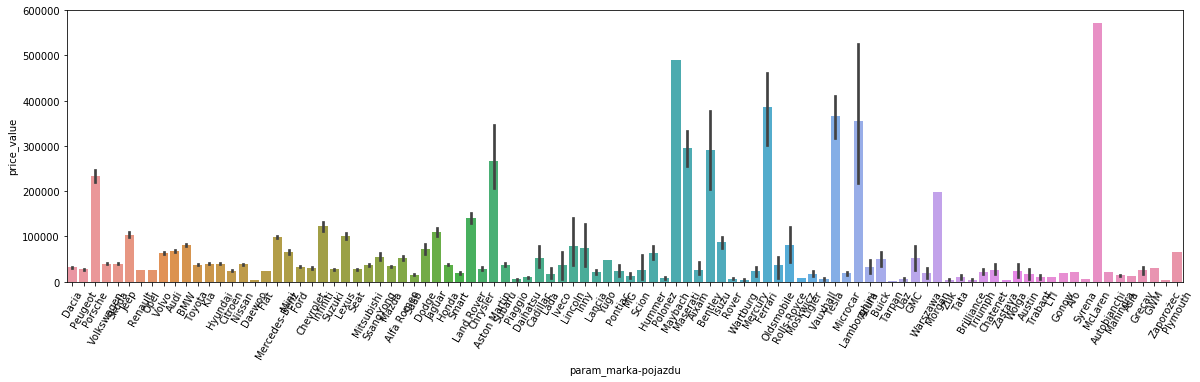

In [21]:
plt.figure(figsize=(20, 5))
sns.barplot(x="param_marka-pojazdu", y="price_value", data=train)
plt.xticks(rotation=60);

In [359]:
X_test_out = test[feats].values
model_out = score
test_out = model_out.predict(X_test_out)
test_out = np.exp(test_out)
test_out

array([ 6062.676, 69809.5  , 11519.496, ...,  8751.093, 21008.984,
       47254.027], dtype=float32)

In [718]:
train['param_body-type'].value_counts()
# train["param_fuel-type"].value_counts()
# train.price_value.max()


Sedan            17
Kombi            17
Minivan          13
Kompakt          13
SUV              10
Auta miejskie     9
Coupe             2
Kabriolet         1
Auta małe         1
Name: param_body-type, dtype: int64

<Figure size 2880x360 with 0 Axes>

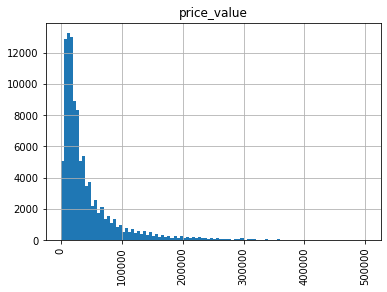

In [79]:
plt.figure(figsize=(40, 5))
train_99prc = train[train.price_value < np.percentile( train.price_value, 99.7 )]
train.hist("price_value" ,bins=100);
plt.xticks(rotation=90);

## Submission
Trzeba przygotować plik, który będzie zawierał: `car_id` i `price`.

In [360]:
global_min = train.price_value.min()
y_pred = test_out
y_pred[ y_pred < global_min] = global_min

test['price_value'] = y_pred

#prepare to submit
test[ ['car_id', 'price_value'] ].to_csv('../output/car_price_simble_log_xgb_and_factorize_18.csv', index=False)

In [81]:
#train.to_hdf('my_train.realestate.h5', 'data') #zapisze w katalogu `/notebooks`

![](../images/dummy_benchmark.png)